In [15]:
import matplotlib.pyplot as mplt
import numpy as np
import ast
import os


# set matplotlib to print inline (Jupyter)
%matplotlib inline

pth = '../data/dump/'
files = os.listdir(pth)

def readDump(source):
    with open(pth + source, 'rb') as ff:
        out = ff.read()
        out = out.decode('utf-8')
        return out.split('\n')

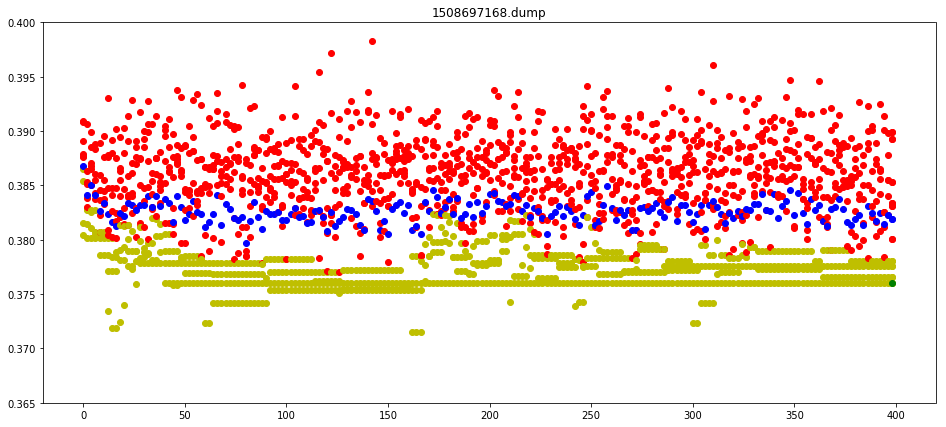

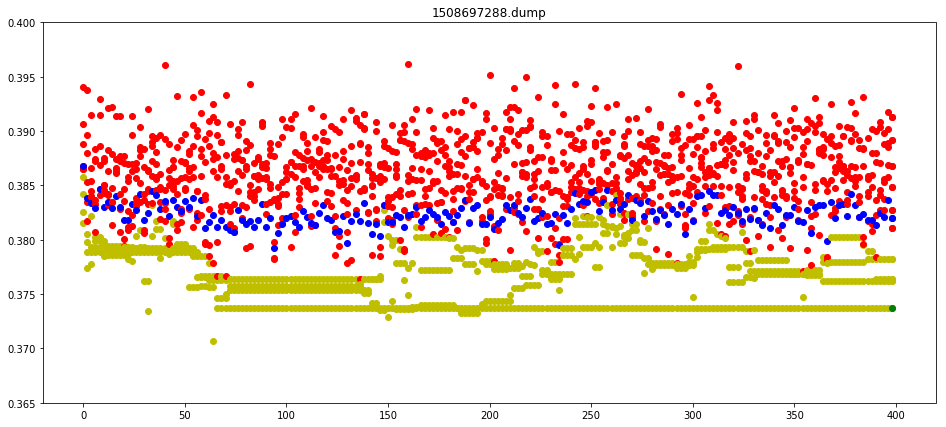

In [ ]:
for f in files:
    raw_data = readDump(f)[2:]
    sep_gens = [raw_data[i-4: i] for i in range(4, len(raw_data), 4)]
    gen_num = [int(j.split('***')[1]) for j in [i[0] for i in sep_gens]]
    gen_fit = [ast.literal_eval(i[2]) for i in sep_gens]
    gen_sur = [ast.literal_eval(i[3]) for i in sep_gens]
    
    # plotting data
    mplt.figure(figsize=(16, 7))
    mplt.title(f)
    mplt.ylim((0.365, 0.4))
    view_gens = [gen_num[i] for i in range(0, len(gen_num), 2)]
    view_gens.append(gen_num[-1])
    for i in view_gens:
        avg = 0
        for j in range(len(gen_fit[i])):
            avg += gen_fit[i][j]
            if j not in gen_sur[i]:
                mplt.scatter(gen_num[i], gen_fit[i][j], color='r')
            else:
                mplt.scatter(gen_num[i], gen_fit[i][j], color='y')
        avg = avg / len(gen_fit[i])
        mplt.scatter(gen_num[i], avg, color='b')
    mplt.scatter(gen_num[len(gen_num) - 1], min(gen_fit[len(gen_num) - 1]), color='g')
